In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Conv2DTranspose, ReLU, BatchNormalization, LeakyReLU
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time as time

In [ ]:
print(keras.__version__)

2.13.1


In [ ]:
print(tfds.__version__)

4.9.3


In [ ]:
from google.colab import files
files.upload()
from google.colab import drive
drive.mount('/content/drive')

Saving kaggle.json to kaggle.json
Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

In [ ]:
NUM_FILTERS = 64
NUM_EPOCHS = 15

In [ ]:
dataset = tfds.load(
    name='coil100',
    batch_size=64,
    data_dir = '/content'
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/7200 [00:00<?, ? examples/s]

Shuffling /content/coil100/2.0.0.incomplete3D687T/coil100-train.tfrecord*...:   0%|          | 0/7200 [00:00<?…

Dataset coil100 downloaded and prepared to /content/coil100/2.0.0. Subsequent calls will reuse this data.


In [ ]:
def plot_image(image, dim, scaled):
  if dim == 4:
    image = tf.squeeze(image, axis=0)
    if scaled == 'no':
      plt.imshow(image.numpy().astype('uint8'))
      plt.show()
    elif scaled == 'yes':
      plt.imshow(image.numpy().astype('uint8')*255)
      plt.show()
  else:
    image = image
    if scaled == 'no':
      plt.imshow(image.numpy().astype('uint8'))
      plt.show()
    elif scaled == 'yes':
      plt.imshow(image.numpy().astype('uint8')*255)
      plt.show()

In [ ]:
def add_noise(image):
  noise = tf.random.normal([128, 128, 3], 0, 1.0)
  return image + noise

In [ ]:
from tensorflow_datasets.core.utils.tf_utils import nogpu_session
features = {
    'image': tf.io.FixedLenFeature([], tf.dtypes.string)
}
path = "/content/coil100/2.0.0/coil100-train.tfrecord-00000-of-00001"
dataset = tf.data.TFRecordDataset(path)
def parse_single_ex(example):
  return tf.io.parse_single_example(example, features=features)
def decode_image(image):
  image = image['image']
  image = tf.io.decode_image(image)
  return image/255
def load_dataset(dataset):
  dataset = dataset.map(parse_single_ex, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(64)
  dataset = dataset.shuffle(1024)
  return dataset
dataset = load_dataset(dataset)
for i in dataset.take(1):
  noise = tf.random.normal(shape=i[0].shape, mean=0.0, stddev=(25)/(255), dtype=tf.float32)
  image = tf.cast(i[0], tf.float32)
  image = image + noise
  image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1.0)

In [ ]:
inpt = tf.keras.Input(shape=(128, 128, 3))
class Encoder_Decoder(tf.keras.Model):
  def __init__(self, num_filters):
    super(Encoder_Decoder, self).__init__()
    self.conv_in = Conv2D(filters=num_filters*2, kernel_size=(3, 3), strides=1, padding='same')
    self.conv_out = Conv2D(filters=3, kernel_size=(3, 3), strides=1, padding='same', activation='sigmoid')
    self.conv_enc = Conv2D(filters=num_filters, kernel_size=(3, 3), strides=2, padding='same')
    self.conv_enc_2 = Conv2D(filters=num_filters/2, kernel_size=(3, 3), strides=2, padding='same')
    self.conv_enc_3 = Conv2D(filters=num_filters/4, kernel_size=(3, 3), strides=2, padding='same')
    self.dconv_in = Conv2DTranspose(filters=num_filters/4, kernel_size=(3, 3), strides=2, padding='same')
    self.dconv_dec = Conv2DTranspose(filters=num_filters/2, kernel_size=(3, 3), strides=2, padding='same')
    self.dconv_dec_2 = Conv2DTranspose(filters=num_filters, kernel_size=(3, 3), strides=2, padding='same')
    self.dconv_dec_3 = Conv2DTranspose(filters=num_filters*2, kernel_size=(3, 3), strides=1, padding='same')
    self.relu = ReLU()
    self.lrelu = LeakyReLU(0.1)
  def forward(self, input):
    x = self.conv_in(input)
    x = self.relu(x)
    x = self.conv_enc(x)
    x = self.relu(x)
    x = self.conv_enc_2(x)
    x = self.relu(x)
    x = self.conv_enc_3(x)
    x = self.relu(x)
    x = self.dconv_in(x)
    x = self.lrelu(x)
    x = self.dconv_dec(x)
    x = self.lrelu(x)
    x = self.dconv_dec_2(x)
    x = self.lrelu(x)
    x = self.dconv_dec_3(x)
    x = self.lrelu(x)
    x = self.conv_out(x)
    return x
AutoEncoder_Model = tf.keras.Model(inputs=inpt, outputs=Encoder_Decoder(NUM_FILTERS).forward(inpt))
AutoEncoder_Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 128)        3584      ['input_1[0][0]']             
                                                                                                  
 re_lu (ReLU)                multiple                     0         ['conv2d[0][0]',              
                                                                     'conv2d_2[0][0]',            
                                                                     'conv2d_3[0][0]',            
                                                                     'conv2d_4[0][0]']        

In [ ]:
loss_fun = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(1e-3)

In [ ]:
@tf.function
def training_step(x):
  noise = tf.random.normal(shape=x.shape, mean=0.0, stddev=(50)/(255), dtype=tf.float32)
  image = tf.cast(x, tf.float32)
  image = image + noise
  noise_image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1.0)
  with tf.GradientTape() as tape:
    prediction = AutoEncoder_Model(noise_image, training=True)
    loss = loss_fun(x, prediction)
  gradients = tape.gradient(loss, AutoEncoder_Model.trainable_weights)
  optimizer.apply_gradients(zip(gradients, AutoEncoder_Model.trainable_weights))
  return loss

In [ ]:
AutoEncoder_Model.load
for epoch in range(NUM_EPOCHS):
  start_time = time.time()
  print(f'Start of epoch {epoch}')
  for step, images in enumerate(dataset):
    tr = training_step(images)
  print(f'End of epoch {epoch}, loss {tr}')
AutoEncoder_Model.save(
    '/content/drive/MyDrive/AutoEncoderWeights/'
)

Start of epoch 0
End of epoch 0, loss 0.0019052732968702912
Start of epoch 1
End of epoch 1, loss 0.0015970752574503422
Start of epoch 2
End of epoch 2, loss 0.0017156230751425028
Start of epoch 3
End of epoch 3, loss 0.0015031503280624747
Start of epoch 4
End of epoch 4, loss 0.0014968292089179158
Start of epoch 5
End of epoch 5, loss 0.0015871390933170915
Start of epoch 6
End of epoch 6, loss 0.0014958695974200964
Start of epoch 7
End of epoch 7, loss 0.001626405748538673
Start of epoch 8
End of epoch 8, loss 0.0013789774384349585
Start of epoch 9
End of epoch 9, loss 0.0013410543324425817
Start of epoch 10
End of epoch 10, loss 0.001436532591469586
Start of epoch 11
End of epoch 11, loss 0.0014979074476286769
Start of epoch 12
End of epoch 12, loss 0.0014097047969698906
Start of epoch 13
End of epoch 13, loss 0.0012515659909695387
Start of epoch 14


End of epoch 14, loss 0.0013584594707936049


1/1 [==============================] - 0s 139ms/step


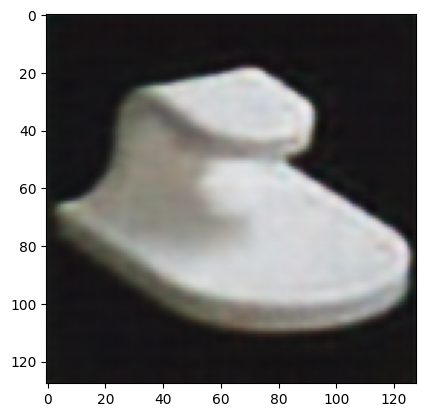

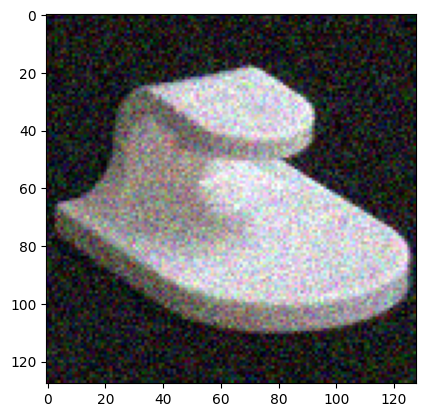

In [ ]:
import keras
Model = keras.models.load_model('/content/drive/MyDrive/AutoEncoderWeights/')
for i in dataset.take(1):
  noise = tf.random.normal(shape=i[0].shape, mean=0.0, stddev=(25)/(255), dtype=tf.float32)
  image = tf.cast(i[0], tf.float32)
  image = image + noise
  noise_image_t = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1.0)
  noise_image = tf.expand_dims(noise_image_t, 0)
  result = Model.predict(noise_image)
  result = tf.squeeze(result, 0)
  plt.imshow(result.numpy())
  plt.show()
  plt.imshow(noise_image_t.numpy())
  plt.show()